# **Lab 5 Concept-based Explainable AI**



---


**Teaching assistant**: Gabriele Ciravegna ( gabriele.ciravegna@polito.it) , Eleonora Poeta ( eleonora.poeta@polito.it )

**Lab 5**: Concept-based XAI - CBM

# **CBM**



---

# **Exercise 1**

In this exercise you have to train a [Concept Bottleneck Model](https://arxiv.org/pdf/2007.04612) (CBM) on the MNIST even/odd dataset.

Specifically you will:



1.   Create the **MNIST even/odd Dataset**. In this variant of MNIST the task is to predict if the digit is even or odd.
> * In addition, you have to predict the **concepts** ( in this case the **concepts are the digits** ).
> * Create the train and test dataset.


2.   Create the **CBM** model.
> * Instanciate the ResNet18 from torchvision.models
> * Retrieve the number of features from the Fully connect of the ResNet.
> * Create the digits (concepts) classifier. This is the concept bottleneck of the network.
> * Create the task classifier (even/odd).

3. Define the **loss** for the problem.
> * The CrossEntropy loss for the concepts.
> * The CrossEntropy loss for the task.

4. Train and test the model.

5. Visualize a few predictions.






---

## Solution:

Imports

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


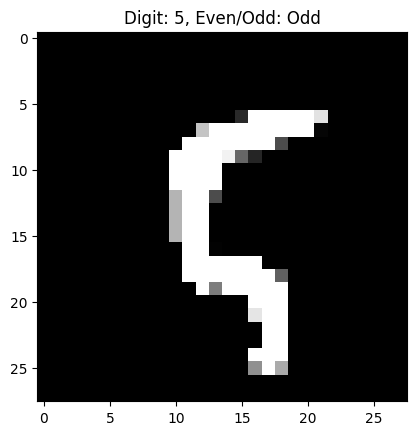

In [3]:
# Class to create the MNIST-EVENODD dataset
class MNISTEvenOdd(torchvision.datasets.MNIST):

    # Constructor for the MNISTEvenOdd class
    def __init__(self, root, train=True, download=False):
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,)), # MNIST mean and std
                                        transforms.Lambda(lambda x: x.repeat(3, 1, 1)) # Repeat the image in 3 channels
                                        ])

        # Call the constructor of the parent class (MNIST)
        super(MNISTEvenOdd, self).__init__(root, train, transform, download=download)

        # Reduce the size of the dataset for the exercise
        self.data = self.data[:10000]
        self.targets = self.targets[:10000]

    # Method to get an item from the dataset
    def __getitem__(self, index):
        # Get the image and target at the given index from the parent class
        img, target = super(MNISTEvenOdd, self).__getitem__(index)

        # define the concept label
        concept = target

        # define the task label as even or odd
        task = target % 2

        # Return the image, concept and task labels
        return img, concept, task

# instantiate the dataset
train_dataset = MNISTEvenOdd(root='.',
                             train=True)

test_dataset = MNISTEvenOdd(root='.',
                            train=False)

# Visualize the dataset
import matplotlib.pyplot as plt

# Get the first image and target from the training dataset
image, target, even_odd = train_dataset[100]

# Plot the image
plt.imshow(image.squeeze().numpy().transpose(1,2,0), cmap='gray')
plt.title(f'Digit: {target}, Even/Odd: {"Odd" if even_odd == 1 else "Even"}')
plt.show()

In [4]:
image.shape

torch.Size([3, 28, 28])

In [5]:
from torchvision import models
class CBM(nn.Module):
    def __init__(self, num_concepts=10, num_classes=2):
        super(CBM, self).__init__()
        # Load the ResNet18 model
        self.resnet = models.resnet18(pretrained=True)

        # Remove the final fully connected layer
        self.resnet.fc = nn.Identity()  # Set the last fully connected layer to an identity layer

        # Get the number of features in the ResNet18 classifier
        num_ftrs = 512  # This is the size of features before the final classification layer

        # Create the digit classifier
        self.digit_classifier = nn.Linear(num_ftrs, num_concepts)

        # Create the even/odd classifier on top of the digit classifier
        self.even_odd_classifier = nn.Linear(num_concepts, num_classes)

    def forward(self, x):
        # Forward pass through the ResNet18
        x = self.resnet(x)

        # Forward pass through the digit classifier
        digit = self.digit_classifier(x)

        # Forward pass through the even/odd classifier
        even_odd = self.even_odd_classifier(digit)

        return digit, even_odd

# Create the model
model = CBM()
model = model.eval()

# Make a forward pass with the model
digit, even_odd = model(image.unsqueeze(0))

# Print the output shapes and the associated logits with two digits precision
print('Digit:', digit.shape, digit.detach().numpy().round(2))
print('Even/Odd:', even_odd.shape, even_odd.detach().numpy().round(2))


c:\Users\a_h9\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\a_h9\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Digit: torch.Size([1, 10]) [[ 0.04 -0.83  0.45 -0.15  0.08 -0.34 -0.23  0.04  0.28  0.17]]
Even/Odd: torch.Size([1, 2]) [[ 0.36 -0.16]]


In [6]:
# train the model
# train the model
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the batch size
batch_size = 128

# Define the number of epochs
num_epochs = 2

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {device}")

Training on cuda


In [8]:
# Train the model
# Iterate over epochs
model = model.to(device)

for epoch in range(num_epochs):

    # Set the model in training mode
    model.train()
    
    # Initialize counters
    correct_digits = 0
    correct_even_odd = 0
    total = 0

    # Iterate over the batches
    for i, (images, concepts, tasks) in enumerate(train_loader):
        # put the image and labels on the device
        images = images.to(device)
        concepts = concepts.to(device)
        tasks = tasks.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        digit, even_odd = model(images)
        
        # Compute the loss for the digit classification
        loss_digit = criterion(digit, concepts)

        # Compute the loss for the even/odd classification
        loss_even_odd = criterion(even_odd, tasks)

        # Parameter gamma
        gamma = 0.5

        # Compute the total loss
        loss = loss_digit + gamma * loss_even_odd
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Compute accuracy
        _, predicted_digits = torch.max(digit.data, 1)
        _, predicted_even_odd = torch.max(even_odd.data, 1)
        total += concepts.size(0)
        correct_digits += (predicted_digits == concepts).sum().item()
        correct_even_odd += (predicted_even_odd == tasks).sum().item()
        
        # Print the loss and accuracy every 10 iterations
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Digit Accuracy: {:.2f}%, Even/Odd Accuracy: {:.2f}%'
            .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item(),
                100 * correct_digits / total, 100 * correct_even_odd / total))

Epoch [1/2], Step [10/79], Loss: 0.6506, Digit Accuracy: 70.39%, Even/Odd Accuracy: 81.95%
Epoch [1/2], Step [20/79], Loss: 0.2382, Digit Accuracy: 81.84%, Even/Odd Accuracy: 89.22%
Epoch [1/2], Step [30/79], Loss: 0.3015, Digit Accuracy: 86.02%, Even/Odd Accuracy: 91.90%
Epoch [1/2], Step [40/79], Loss: 0.0960, Digit Accuracy: 88.20%, Even/Odd Accuracy: 93.34%
Epoch [1/2], Step [50/79], Loss: 0.1949, Digit Accuracy: 89.95%, Even/Odd Accuracy: 94.31%
Epoch [1/2], Step [60/79], Loss: 0.3361, Digit Accuracy: 90.89%, Even/Odd Accuracy: 94.91%
Epoch [1/2], Step [70/79], Loss: 0.1331, Digit Accuracy: 91.66%, Even/Odd Accuracy: 95.33%
Epoch [2/2], Step [10/79], Loss: 0.1534, Digit Accuracy: 95.62%, Even/Odd Accuracy: 98.05%
Epoch [2/2], Step [20/79], Loss: 0.1343, Digit Accuracy: 96.02%, Even/Odd Accuracy: 98.20%
Epoch [2/2], Step [30/79], Loss: 0.0829, Digit Accuracy: 96.64%, Even/Odd Accuracy: 98.36%
Epoch [2/2], Step [40/79], Loss: 0.0484, Digit Accuracy: 96.82%, Even/Odd Accuracy: 98.48%

In [12]:
# Evaluate the model on the test set
model.eval()
# Initialize the accuracy
correct = 0
# Disable gradient computation
with torch.no_grad():
    # Iterate over the test set
    for images, concepts, tasks in test_loader:
        # put the image and labels on the device
        images = images.to(device)
        concepts = concepts.to(device)
        tasks = tasks.to(device)
        # Forward pass
        digit, even_odd = model(images)
        
        # Get the predicted digit
        _, predicted_digit = digit.max(1)

        # Get the predicted even/odd
        _, predicted_even_odd = even_odd.max(1)

        # Update the number of correct predictions
        correct += (predicted_digit == concepts).sum().item() + (predicted_even_odd == tasks).sum().item()

# Compute the accuracy
accuracy = correct / (len(test_dataset)*2)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

Accuracy: 98.35%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


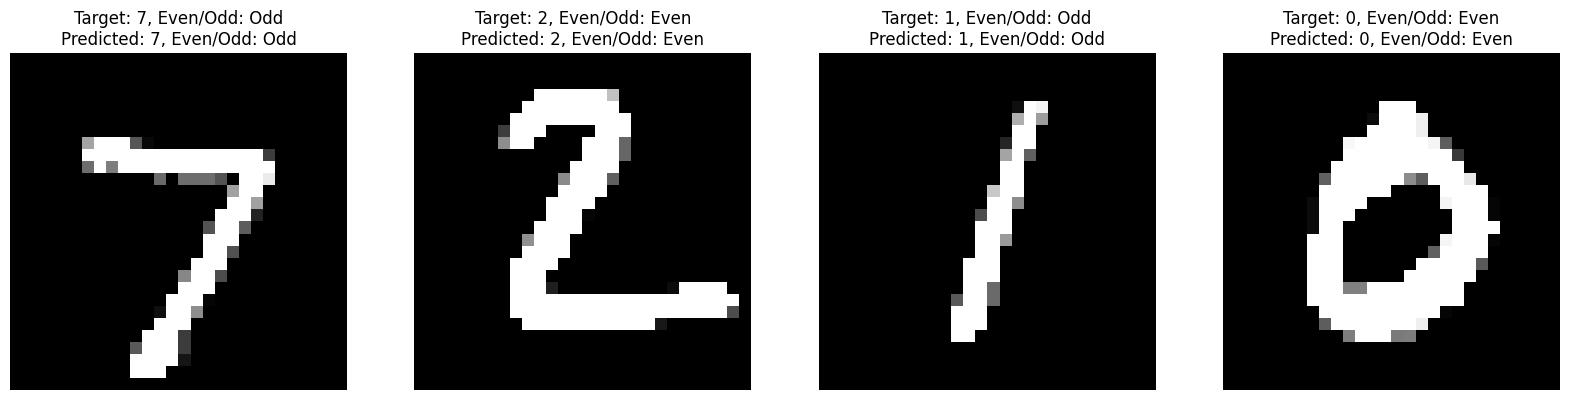

In [13]:
# Visualize a few predictions
import numpy as np

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    # Get the image and target from the test dataset
    image, target, even_odd = test_dataset[i]

    # Make a forward pass
    predicted_digit, predicted_even_odd = model(image.unsqueeze(0).to(device))

    # Get the predicted digit
    _, predicted_digit = torch.max(predicted_digit, 1)

    # Get the predicted even/odd
    _, predicted_even_odd = torch.max(predicted_even_odd, 1)

    # Plot the image
    axes[i].imshow(image.squeeze().numpy().transpose(1,2,0), cmap='gray')
    axes[i].set_title(f'Target: {target}, Even/Odd: {"Odd" if even_odd else "Even"}\n'
                      f'Predicted: {predicted_digit.item()}, Even/Odd: {"Odd" if predicted_even_odd.item() else "Even"}')
    axes[i].axis('off')
plt.show()
